booster ='gblinear',objective = 'count:poisson'
https://xgboost.readthedocs.io/en/latest/python/python_intro.html#training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

import time

In [2]:
test = pd.read_pickle('./data/prepro3test.pkl')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426000 entries, 0 to 6425999
Data columns (total 7 columns):
 #   Column            Dtype
---  ------            -----
 0   datenum           int16
 1   shop_id           int16
 2   item_id           int16
 3   item_name         int16
 4   item_category_id  int16
 5   main_cat          int16
 6   sub_cat           int16
dtypes: int16(7)
memory usage: 134.8 MB


In [3]:
train = pd.read_pickle('./data/prepro3train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70512330 entries, 0 to 70512329
Data columns (total 8 columns):
 #   Column            Dtype
---  ------            -----
 0   datenum           int16
 1   shop_id           int16
 2   item_id           int16
 3   item_name         int16
 4   item_category_id  int16
 5   main_cat          int16
 6   sub_cat           int16
 7   item_cnt_day      int16
dtypes: int16(8)
memory usage: 1.6 GB


In [4]:
columnX = ['datenum', 'shop_id', 'item_id', 'item_category_id',
       'main_cat', 'sub_cat']
columny = ['item_cnt_day']

In [5]:
# train/validation/test data split, target clip
X_train = train[columnX]
y_train = train[columny]

X_test = test[columnX]

In [10]:
y_train = y_train.clip(0,20)

In [11]:
X_train.shape, y_train.shape, X_test.shape

((70512330, 6), (70512330, 1), (6426000, 6))

In [12]:
xgb_model = XGBRegressor(booster ='gblinear',objective = 'count:poisson')

In [13]:
start = time.time()
xgb_model.fit(X_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train, y_train)], 
              verbose=10,
              early_stopping_rounds = 30)

[0]	validation_0-rmse:0.41467
[10]	validation_0-rmse:0.34039
[20]	validation_0-rmse:0.34003
[30]	validation_0-rmse:0.33995
[32]	validation_0-rmse:0.33994


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=0.699999988, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=4, num_parallel_tree=None,
             objective='count:poisson', predictor=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

In [14]:
#time
end = time.time()
print(f'소요시간(s) : {end-start}')

소요시간(s) : 193.37171697616577


In [17]:
#feature imporatance
# plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

ValueError: Image size of 76466x387 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x432 with 1 Axes>

In [18]:
#prediction, validation
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)



print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_pred)))

Train rmse: 0.33601055


In [19]:
test_pred

array([0.06099277, 0.03174818, 0.06089504, ..., 0.02738894, 0.03199475,
       0.03588324], dtype=float32)

In [20]:
test['predict'] = test_pred

In [21]:
test.head()

,datenum,shop_id,item_id,item_name,item_category_id,main_cat,sub_cat,predict
0,1035,5,5037,4182,19,5,12,0.060993
1,1035,5,5320,4275,55,13,4,0.031748
2,1035,5,5233,4147,19,5,12,0.060895
3,1035,5,5232,4147,23,5,18,0.063641
4,1035,5,5268,4139,20,5,13,0.061243


In [22]:
test1= test.groupby(['shop_id', 'item_id']).sum()

In [23]:
test1 = test1.reset_index()

In [24]:
test1['predict']=test1.predict.clip(0,20)

In [25]:
test1

,shop_id,item_id,datenum,item_name,item_category_id,main_cat,sub_cat,predict
0,2,30,31485.0,30.0,1200.0,330.0,180.0,1.198099
1,2,31,31485.0,30.0,1110.0,330.0,30.0,1.153288
2,2,32,31485.0,60.0,1200.0,330.0,180.0,1.198080
3,2,33,31485.0,60.0,1110.0,330.0,30.0,1.153269
4,2,38,31485.0,150.0,1230.0,330.0,1110.0,1.630949
...,...,...,...,...,...,...,...,...
214195,59,22162,31485.0,543600.0,1200.0,330.0,180.0,0.927889
214196,59,22163,31485.0,543600.0,1200.0,330.0,180.0,0.927882
214197,59,22164,31485.0,543600.0,1110.0,330.0,30.0,0.893177
214198,59,22166,31485.0,543330.0,1620.0,360.0,1890.0,1.476508


/Users/koossen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predict'>

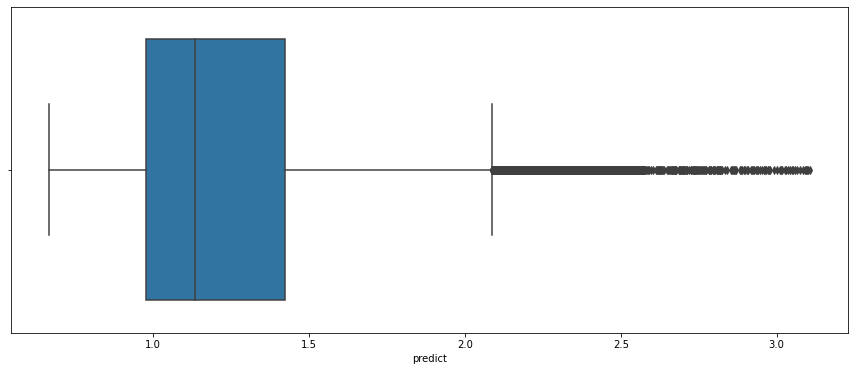

In [26]:
sns.boxplot(test1.predict)

In [27]:
testoriginal = pd.read_csv('./data/test.csv')

In [28]:
testoriginal.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [29]:
testoriginal = testoriginal.merge(test1, on= ['item_id', 'shop_id'], how = 'left')

In [30]:
testoriginal.head()

,ID,shop_id,item_id,datenum,item_name,item_category_id,main_cat,sub_cat,predict
0,0,5,5037,31485.0,125460.0,570.0,150.0,360.0,1.820649
1,1,5,5320,31485.0,128250.0,1650.0,390.0,120.0,0.947691
2,2,5,5233,31485.0,124410.0,570.0,150.0,360.0,1.817733
3,3,5,5232,31485.0,124410.0,690.0,150.0,540.0,1.899692
4,4,5,5268,31485.0,124170.0,600.0,150.0,390.0,1.828114


In [31]:
testfinal = testoriginal[['ID', 'predict']]

In [32]:
testfinal.columns = ['ID', 'item_cnt_month']

In [33]:
# 제출 파일 생성
testfinal.to_csv('sek_xgb3_2_submit.csv', index=False)